# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.900038,True,6.845459
1,-1.236128,True,-1.506835
2,1.499761,True,9.864456
3,-0.271229,False,-1.502530
4,0.841570,True,6.080452
...,...,...,...
995,0.355837,True,6.426948
996,-3.102562,False,-8.022928
997,1.876890,True,9.204710
998,-0.734564,False,-0.378092


<AxesSubplot:xlabel='v0'>

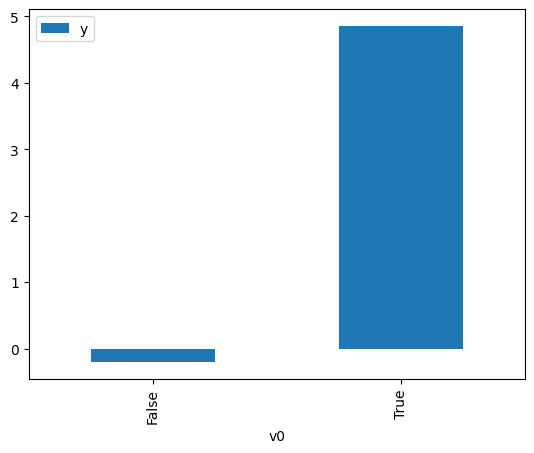

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

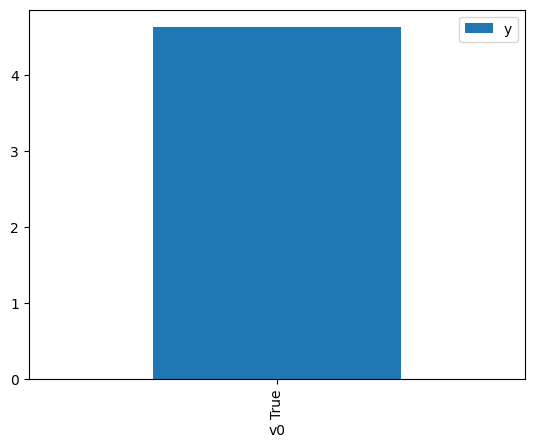

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.187817,False,2.689469,0.489307,2.043708
1,-0.852150,False,-2.157291,0.641160,1.559673
2,-1.007518,False,-2.535518,0.662287,1.509919
3,0.460081,False,0.999806,0.448699,2.228665
4,0.541909,False,4.067251,0.436603,2.290413
...,...,...,...,...,...
995,-0.883674,False,-2.190034,0.645494,1.549200
996,-0.779049,False,-2.772102,0.631021,1.584734
997,-1.101801,False,-3.352473,0.674806,1.481908
998,-0.268489,False,-0.212429,0.557409,1.794014


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.772859,True,2.741134,0.243770,4.102229
1,0.719592,True,6.723296,0.589388,1.696675
2,-1.874612,True,0.980969,0.232706,4.297269
3,0.236150,True,5.130268,0.517928,1.930771
4,-2.311892,True,-0.929296,0.189214,5.285026
...,...,...,...,...,...
995,0.110461,True,5.222962,0.499106,2.003581
996,0.154722,True,4.345454,0.505737,1.977314
997,-0.518679,True,2.918938,0.405988,2.463127
998,-0.092023,True,4.630142,0.468813,2.133046


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.205e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        17:04:38   Log-Likelihood:                         -1391.3
No. Observations:                1000   AIC:                                      2787.
Df Residuals:                     998   BIC:                                      2796.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6325      0.031     85.127      0.000       2.572       2.693
x2             4.9799      0.045    110.110      0.000       4.891       5.069
==============================================================================
Omnibus:                        1.971   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.373   Jarque-Bera (JB):                1.832
Skew:                          -0.093   Prob(JB):                        0.400
Kurtosis:                       3.096   Cond. No.                         1.54
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""